In [1]:
#Projet Mogpl M1 Informatique
#Dice Battle

#Yuhan WANG & Yufei LIU

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import sys
from gurobipy import *
import tkinter as tk
from PIL import Image
from PIL import ImageTk
from tkinter import messagebox
import PIL


#variable global N est le point cible et D est le nombre de dés qu'on peut lancer maximument chaque fois
#LP = ligne perdu signifie que si joueur1 a moins de cette ligne et joueur 2 a N-1 point alors joueur1 a perdu
N = 100
D = 10
LP = N - 6 * D

#Q1
class tab_p(object):
    
    def __init__(self, d):
        """
        entrée : le nombre de dés
        sortie : Q_tab et P_tab initialisé
        """
        self.D = d
        self.Q_tab=np.ones((self.D+1,6*self.D+1))*-1
        for a in range(0,6*self.D+1):
            self.Q_tab[0,a]=0
        for b in range(0,self.D+1):
            self.Q_tab[b,0]=0
        for i in range (2,7):
            #la propabilité d'obtenir 1 avec d dés
            self.Q_tab[1,i]=1/5
        
        self.P_tab=np.ones((self.D+1,6*self.D+1))*-2
        for c in range(0,self.D+1):
            self.P_tab[c,0]=0
            self.P_tab[c,1]=1-np.power(5/6,c)
        for d in range(0,6*self.D+1):
            self.P_tab[0,d]=0
            
            
    def Q(self,d,k):
        if d<=0:
            return 0
        if k<=0 | ((k>1) & (k<2*d)) | k>6*d :
            return 0
        else:
            if(self.Q_tab[d,k]!=-1):
                #print(d,k,Q_tab[d,k])
                return self.Q_tab[d,k]
            else:
                res = 0
                for j in range(2,7):
                    #print(d-1,k-j)
                    if(self.Q_tab[d-1,k-j]==-1):
                        self.Q_tab[d-1,k-j]=self.Q(d-1,k-j)
                    res += self.Q(d-1,k-j)
                return res/5
            
    def P(self,d,k):
        if(k==1):
            return self.P_tab[d,1]
        if self.P_tab[d,k]!=-2:
            return self.P_tab[d,k]
        else:
            self.P_tab[d,k]=(5/6)**d*self.Q(d,k)
            return self.P_tab[d,k]

    
    
global TAB_P
TAB_P = tab_p(D)

In [4]:
#Q2

def calcul_EP(d):
    return 4*d*(5/6)**d + 1 - (5/6)**d

print(calcul_EP(5))
print(calcul_EP(6))
#On doit choisir d*=6 car EP(6) est supérieur de EP(5)




8.63567386831276
8.702653463648836


In [5]:
class strategie_optimal(object):
    def __init__(self, D, N):
        self.N = N
        self.D = D
        self.tab = np.ones((N,N))*100
        self.best_choice = np.zeros((N,N))
        global TAB_P
        if D>TAB_P.D:
            TAB_P = tab_p(D)
         
    def EG(self,i,j):
        if(i>=self.N):
            return 1
        elif(j>=self.N):
            return -1
        elif self.tab[i][j]<100:
            return self.tab[i][j]
        
        exps=[]
        for d1 in range(1,self.D+1):
            exp=0
            for e1 in range(1,6*d1+1):
                exp += TAB_P.P(d1,e1) * self.EG(j,i+e1)
            exps.append(-exp)
        self.tab[i][j]=max(exps)
        self.best_choice[i][j]=int(np.argmax(exps)+1)
        #self.best_choice[i][j]=int(np.argmax(exps))
        return self.tab[i][j]
    
    def choice_optimal(self,i,j):
        if self.best_choice[i][j]<1:
            t = self.EG(i,j)
        return self.best_choice[i][j]
    

In [6]:
#Q7
class strategie_aveugle(object):
    def __init__(self, D, N):
        self.N = N
        self.D = D
        
    def choice_optimal(self,i,j):
        if self.D > 5:
            return 6
        return self.D
    
stra_opt1 = strategie_optimal(10,100)
stra_opt1 = strategie_optimal(10,100)
#def strategie_optimale(i,j):


In [7]:
class strategie_aleatoire(object):
    def __init__(self, D, N):
        self.N = N
        self.D = D
        
    def choice_optimal(self,i,j):
        return random.randint(1 , self.D)

In [8]:
#Q8
def get_random_score(d):
    res = 0
    for i in range(int(d)):
        tmp = random.randint(1 , 6)
        if(tmp==1):
            return 1
        res += tmp
    return res


def game_ai(n,stra1,stra2,from_i, from_j):
    state=[from_i,from_j]
    while(state[1]<n)&(state[0]<n):
        #print("Score of player1: ",state[0],"\n Score of player2: ",state[1],"\n")
        d1 = int(stra1.choice_optimal(state[0],state[1]))
        p1 = get_random_score(d1)
        #temp = state[0]
        state[0] += p1
        #print("AI111 get ",p1, "score with ",d1," dice(s)!\n")
        if(state[0]>=n):
            return 1
        d2 = int(stra2.choice_optimal(state[1],state[0]))
        p2 = get_random_score(d2)
        state[1] += p2
        #print("AI222 get ",p2, "score with ",d2," dice(s)!\n")
        if(state[1]>=n):
            return -1

In [9]:
def test_D(D,N):
    n_test = 1000
    n_intervalle = 10
    ds = [ int(D*i/n_intervalle) for i in range(1,1+n_intervalle)]
    res = np.zeros((8,n_intervalle))
    #res = [aa,ao,oa,oo]
    for di in range(len(ds)):
        res_aa = 0
        res_ao = 0
        res_oa = 0
        res_oo = 0
        res_la = 0
        res_lo = 0
        res_al = 0
        res_ol = 0
        stra_opt = strategie_optimal(ds[di],N)
        stra_avg = strategie_aveugle(ds[di],N)
        stra_ale = strategie_aleatoire(ds[di],N)
        for i in range(n_test):
            res_aa += game_ai(N,stra_avg,stra_avg,0,0)
            res_ao += game_ai(N,stra_avg,stra_opt,0,0)
            res_oa += game_ai(N,stra_opt,stra_avg,0,0)
            res_oo += game_ai(N,stra_opt,stra_opt,0,0)
            res_la += game_ai(N,stra_ale,stra_avg,0,0)
            res_lo += game_ai(N,stra_ale,stra_opt,0,0)
            res_al += game_ai(N,stra_avg,stra_ale,0,0)
            res_ol += game_ai(N,stra_opt,stra_ale,0,0)
            
        res[0][di] = res_aa / n_test
        res[1][di] = res_ao / n_test
        res[2][di] = res_oa / n_test
        res[3][di] = res_oo / n_test
        res[4][di] = res_la / n_test
        res[5][di] = res_lo / n_test
        res[6][di] = res_al / n_test
        res[7][di] = res_ol / n_test
        
    plt.plot(ds , res[0], c='r')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 aveugle & J2 aveugle")
    plt.show()
    
    plt.plot(ds , res[1], c='blue')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 aveugle & J2 optimal")
    plt.show()
    
    plt.plot(ds , res[2], c='y')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 optimal & J2 aveugle")
    plt.show()
    
    plt.plot(ds , res[3], c='black')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 optimal & J2 optimal")
    plt.show()
    
    plt.plot(ds , res[4], c='green')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 aléatoire & J2 aveugle")
    plt.show()
    
    plt.plot(ds , res[5], c='orange')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 aléatoire & J2 optimal")
    plt.show()
    
    plt.plot(ds , res[6], c='pink')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 aveugle & J2 aléatoire")
    plt.show()
    
    plt.plot(ds , res[7], c='cyan')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 optimal & J2 aléatoire")
    plt.show()
    return res

In [10]:
def test_N(D,N):
    n_test = 1000
    n_intervalle = 100
    ns = [ int(N*i/n_intervalle) for i in range(1,1+n_intervalle)]
    res = np.zeros((8,n_intervalle))
    #stra_opt = strategie_optimal(D,N)
    #res = [aa,ao,oa,oo]
    stra_opt = strategie_optimal(D,N)
    stra_avg = strategie_aveugle(D,N)
    stra_ale = strategie_aleatoire(D,N)
    for ni in range(len(ns)):
        res_aa = 0
        res_ao = 0
        res_oa = 0
        res_oo = 0
        res_la = 0
        res_lo = 0
        res_al = 0
        res_ol = 0
        for i in range(n_test):
            res_aa += game_ai(N,stra_avg,stra_avg,N-ns[ni],N-ns[ni])
            res_ao += game_ai(N,stra_avg,stra_opt,N-ns[ni],N-ns[ni])
            res_oa += game_ai(N,stra_opt,stra_avg,N-ns[ni],N-ns[ni])
            res_oo += game_ai(N,stra_opt,stra_opt,N-ns[ni],N-ns[ni])
            res_la += game_ai(N,stra_ale,stra_avg,N-ns[ni],N-ns[ni])
            res_lo += game_ai(N,stra_ale,stra_opt,N-ns[ni],N-ns[ni])
            res_al += game_ai(N,stra_avg,stra_ale,N-ns[ni],N-ns[ni])
            res_ol += game_ai(N,stra_opt,stra_ale,N-ns[ni],N-ns[ni])
            
        res[0][ni] = res_aa / n_test
        res[1][ni] = res_ao / n_test
        res[2][ni] = res_oa / n_test
        res[3][ni] = res_oo / n_test
        res[4][ni] = res_la / n_test
        res[5][ni] = res_lo / n_test
        res[6][ni] = res_al / n_test
        res[7][ni] = res_ol / n_test
        
    plt.plot(ns , res[0], c='r')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 aveugle & J2 aveugle")
    plt.show()
    
    plt.plot(ns , res[1], c='blue')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 aveugle & J2 optimal")
    plt.show()
    
    plt.plot(ns , res[2], c='y')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 optimal & J2 aveugle")
    plt.show()
    
    plt.plot(ns , res[3], c='black')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 optimal & J2 optimal")
    plt.show()
    
    plt.plot(ns , res[4], c='green')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 aléatoire & J2 aveugle")
    plt.show()
    
    plt.plot(ns , res[5], c='orange')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 aléatoire & J2 optimal")
    plt.show()
    
    plt.plot(ns , res[6], c='pink')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 aveugle & J2 aléatoire")
    plt.show()
    
    plt.plot(ns , res[7], c='cyan')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 optimal & J2 aléatoire")
    plt.show()
    return res

In [11]:
stra_opt = strategie_optimal(10,100)

In [11]:
stra_opt.choice_optimal(0,0)

6.0

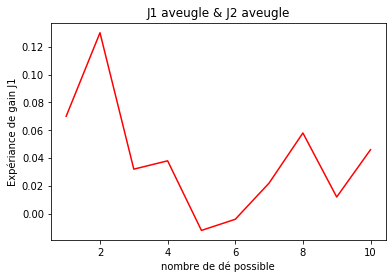

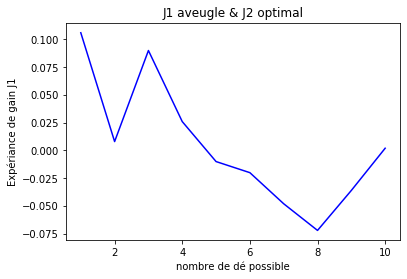

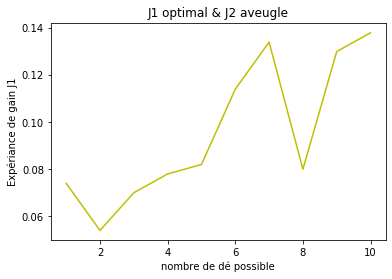

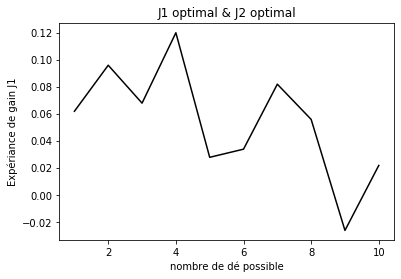

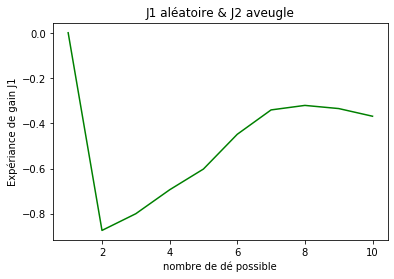

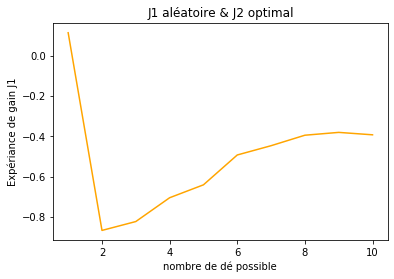

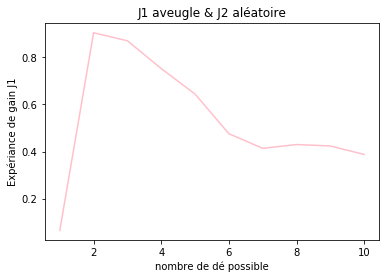

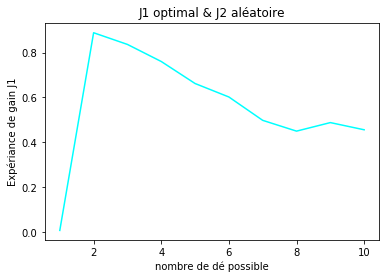

array([[ 0.07 ,  0.13 ,  0.032,  0.038, -0.012, -0.004,  0.022,  0.058,
         0.012,  0.046],
       [ 0.106,  0.008,  0.09 ,  0.026, -0.01 , -0.02 , -0.048, -0.072,
        -0.036,  0.002],
       [ 0.074,  0.054,  0.07 ,  0.078,  0.082,  0.114,  0.134,  0.08 ,
         0.13 ,  0.138],
       [ 0.062,  0.096,  0.068,  0.12 ,  0.028,  0.034,  0.082,  0.056,
        -0.026,  0.022],
       [ 0.002, -0.874, -0.8  , -0.694, -0.602, -0.448, -0.34 , -0.32 ,
        -0.334, -0.368],
       [ 0.114, -0.866, -0.822, -0.704, -0.64 , -0.492, -0.446, -0.394,
        -0.38 , -0.392],
       [ 0.066,  0.904,  0.87 ,  0.752,  0.644,  0.476,  0.414,  0.43 ,
         0.424,  0.388],
       [ 0.008,  0.888,  0.836,  0.76 ,  0.662,  0.602,  0.498,  0.45 ,
         0.488,  0.456]])

In [12]:
test_D(10,200)

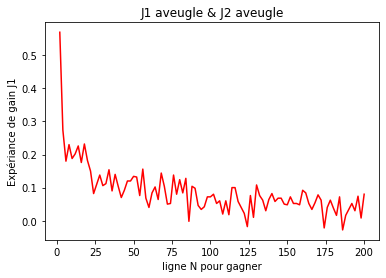

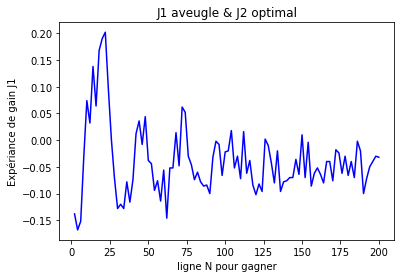

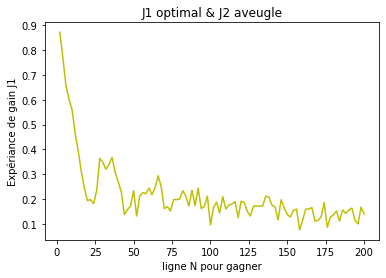

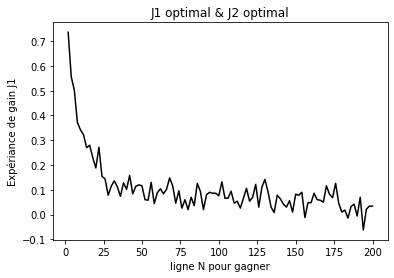

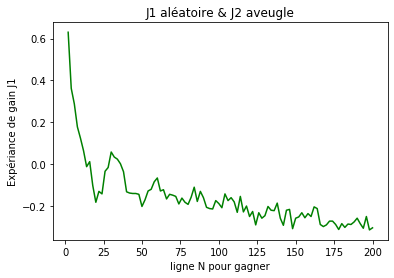

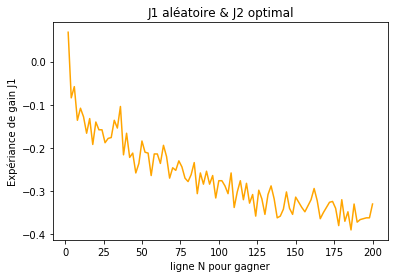

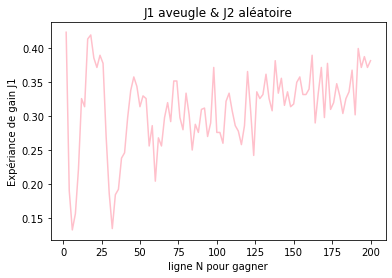

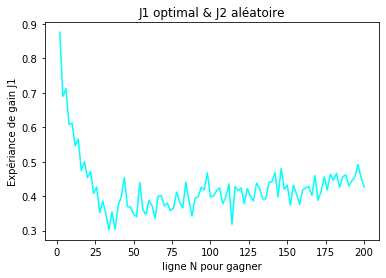

array([[ 0.57 ,  0.274,  0.18 ,  0.23 ,  0.188,  0.202,  0.226,  0.176,
         0.232,  0.182,  0.15 ,  0.082,  0.11 ,  0.138,  0.106,  0.112,
         0.154,  0.09 ,  0.14 ,  0.104,  0.07 ,  0.092,  0.12 ,  0.12 ,
         0.134,  0.132,  0.076,  0.156,  0.068,  0.04 ,  0.084,  0.102,
         0.064,  0.144,  0.104,  0.05 ,  0.052,  0.138,  0.08 ,  0.124,
         0.084,  0.128, -0.002,  0.104,  0.098,  0.046,  0.034,  0.042,
         0.072,  0.072,  0.08 ,  0.052,  0.06 ,  0.02 ,  0.06 ,  0.018,
         0.1  ,  0.1  ,  0.058,  0.04 ,  0.022, -0.018,  0.076,  0.01 ,
         0.108,  0.076,  0.062,  0.03 ,  0.064,  0.082,  0.058,  0.068,
         0.068,  0.05 ,  0.048,  0.072,  0.052,  0.052,  0.048,  0.092,
         0.084,  0.052,  0.034,  0.054,  0.078,  0.062, -0.022,  0.04 ,
         0.062,  0.038,  0.016,  0.072, -0.028,  0.016,  0.034,  0.052,
         0.03 ,  0.074,  0.008,  0.08 ],
       [-0.138, -0.168, -0.152, -0.032,  0.074,  0.032,  0.138,  0.064,
         0.168,  0.19 ,

In [13]:
test_N(10,200)

In [14]:
#print(stra_opt1.EG(95,95))
[stra_opt1.EG(i,99) for i in range(0,100)]
print(stra_opt1.EG(0,0))

0.06871904732303523


In [12]:
#Q9
class game(object):
    def __init__(self, D, N):
        self.N = N
        self.D = D
        self.tab = np.ones((N,N))*100
        
    
    def start_conter_ai(self,strategie):
        state=[0,0]
        tour = 0
        while(state[1]<self.N)&(state[0]<self.N):
            tour += 1
            print("*****************************************\n")
            print("Tour:",tour, "\n Score of player1: ",state[0],"\n Score of player2: ",state[1],"\n Score of target: ",self.N )
            print("You can make a choice between 1 and ",self.D," for this round:")
            d1 = int(input())
            p1 = get_random_score(d1)
            print("You get ",p1, "score with ",d1, " dice(s)!\n")
            state[0]+=p1
            if(state[0]>=self.N):
                break
            d2 = int(strategie.choice_optimal(state[1],state[0]))
            p2 = get_random_score(d2)
            print("AI get ",p2, "score with ",d2," dice(s)!\n")
            state[1]+=p2
            print("\n\n\n\n\n\n")
            
        if state[0]>=self.N:
            print("You win")
        else:
            print("•••You lose•••")
            
            
    
    



In [13]:
#Q10
D1=10
#TAB_P1 = tab_p(D1).P_tab
EG1=np.ones((D1,D1))*-1

def calculer_EG1(D,tab):
    for i in range(1,D1+1):
        for j in range(1,D1+1):
            gain=0
            perd=0
            moin=0
            plus=0
            for a in range(1,6*i+1):
                for b in range(1,6*j+1):
                    if(a>b):
                        plus+=1
                        gain+=tab.P(i,a)*tab.P(j,b)
                    else:
                        if(a<b):
                            moin+=1
                            perd+=tab.P(i,a)*tab.P(j,b)
            if(i==j):
                EG1[i-1,j-1]=0
            else:
                EG1[i-1,j-1]=gain-perd
    return EG1


In [14]:
#Q13
def proglineaire(D):
    
    nb_prob = D.shape[0]
    
    q = []
    
    #matrice de contrainte
    m = Model("s0")
    alpha = m.addVar(vtype=GRB.CONTINUOUS, name="alpha") 
    m.setObjective(alpha,GRB.MINIMIZE)
    
    #le somme des probabilitées egalent à 1
    for i in range(nb_prob):
        q.append(m.addVar(vtype=GRB.CONTINUOUS,lb=0,ub=1,name="p%d"%(i+1)))
        #res=LinExpr()

    
    for i in range(nb_prob):
        expr = LinExpr()
        for j in range(nb_prob): 
            #expr+=D[i,j]*q[j]*(-1) #5:0.61 10:1
            #expr+=D[i,j]*q[j] #5:0.771 10:normal
            #print("D",D[j,i],j)
            expr+=D[j,i]*q[j]*(-1)   
        m.addConstr(alpha>=expr)
        
    expr1 = LinExpr()
    for i in range(nb_prob):
        expr1+=q[i]
    m.addConstr(expr1==1)
    
    
        
    m.optimize()
    return [r.X for r in q]

In [15]:
temp=calculer_EG1(D1,TAB_P)
temp2 = proglineaire(temp)
print(temp2)

Using license file /Users/yufei/gurobi.lic
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 11 rows, 11 columns and 110 nonzeros
Model fingerprint: 0x6241e261
Coefficient statistics:
  Matrix range     [2e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 10 rows, 11 columns, 100 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.526492e-01   0.000000e+00      0s
       6    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
[0.0, 0.17558045512302675, 0.052937507219585234, 0.0, 0.7714820376574066, 0.0, 0.0, 0.0, 0.0, 0.0]


In [61]:
#Q14
def comparer_opt2_aveugle():
    res=np.zeros(10)
    xs=[i for i in range(1,11)]
    nb_test=1000000
    for d in range(1,11):
        global D1
        D1=d
        global EG1
        EG1=np.ones((D1,D1))*-1
        temp=calculer_EG1(D1,TAB_P)
        temp2 = proglineaire(temp)
        
        if(d>=6):
            choix_aveugle=6
        else:
            choix_aveugle=d
        for j in range(nb_test):
            r = random.uniform(0,1)
            choix_opt2=1
            for i in range(len(temp2)):
                if r<=np.sum(temp2[:i+1]):
                    choix_opt2=i+1
                    break
            #print("choix2",choix_opt2,"  choix_av:",choix_aveugle)
            point_opt2=get_random_score(choix_opt2)
            point_aveugle=get_random_score(choix_aveugle)

            if point_opt2>point_aveugle:
                res[d-1] += 1
            elif point_aveugle>point_opt2:
                res[d-1] += (-1)
        res[d-1] = res[d-1]/nb_test
    plt.plot(xs , res, c='cyan')
    plt.xlabel("nombre de dé")
    plt.ylabel("Expériance de gain J1")
    plt.title("J1 optimal2 & J2 aveugle")

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 2 rows, 2 columns and 2 nonzeros
Model fingerprint: 0xe676b28b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 3 rows, 3 columns and 6 nonzeros
Model fingerprint: 0x873585d8
Coefficient statistics:
  Matrix range     [4e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed


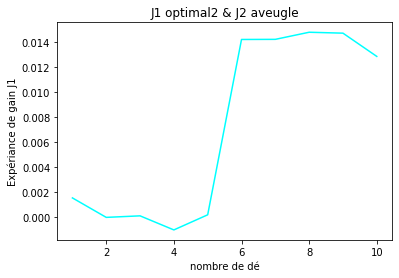

In [62]:
comparer_opt2_aveugle()

In [22]:
D=10
N=100


def win(option):
    if option==1:
        if(messagebox.askretrycancel(message="Player1 win! One more game?")):
            choice()
    else:
        if(messagebox.askretrycancel(message="Player2 win! One more game?")):
            choice()
                
def get_point(nb,nb2,ai):
    global TOUR
    #contre AI
    if nb2==0:
        var_round.set(var_round.get()+1)
        new_pp1=pp1.get()+get_random_score(nb)
        pp1.set(new_pp1)
        if(new_pp1>=N):
            win(1)
        ai_choice = ai.choice_optimal(pp2.get(),new_pp1)
        new_pp2=pp2.get()+get_random_score(ai_choice)
        pp2.set(new_pp2)
        if(new_pp2>=N):
            win(2)

    #player vs player
    else:
        if(TOUR==2):
            var_round.set(var_round.get()+1)
            new_pp2=pp2.get()+get_random_score(nb)
            pp2.set(new_pp2)
            if(new_pp2>=N):
                win(2)
        else:
            new_pp1=pp1.get()+get_random_score(nb)
            pp1.set(new_pp1)
            if(new_pp1>=N):
                win(1)
        if(TOUR==1):
            TOUR=2
            turn_of.set("Now it's turn of player2!")
        else:
            TOUR=1
            turn_of.set("Now it's turn of player1!")


def startAI(stra,option):
    stra.destroy()
    if option==1:
        ai = strategie_aveugle(D,N)
    elif option ==2:
        ai = strategie_optimal(D,N)
    else:
        ai = strategie_aleatoire(D,N)

    pp1.set(0)
    pp2.set(0)
    var_round.set(0)
    l00 = tk.Label(window,text="Round:", bg="LightGreen", font=('Arial',20), width=20,height=5)
    l0 = tk.Label(window,textvariable=var_round, bg="LightGreen", font=('Arial',20), width=20,height=5)
    l11 = tk.Label(window,text="Score Player1", bg="pink", font=('Arial',18), width=20,height=5)
    l1 = tk.Label(window,textvariable=pp1, bg="pink", font=('Arial',18), width=20,height=5)
    l22 = tk.Label(window,text="Score Player2", bg="green", font=('Arial',18), width=20,height=5)
    l2 = tk.Label(window,textvariable=pp2, bg="green", font=('Arial',18), width=20,height=5)
    l00.grid(row=0,column=0)
    l11.grid(row=1,column=0)
    l22.grid(row=2,column=0)
    l0.grid(row=0,column=1)
    l1.grid(row=1,column=1)
    l2.grid(row=2,column=1)
    panel=tk.Label(window)
    b=[]
    for i in range(1,D+1):
        b.append(tk.Button(panel,text=i,font=('Arail',20),background='FloralWhite',width=2,height=2))
        b[i-1].grid(row=0,column=i)

    b[0]['command']=lambda:get_point(1,0,ai)
    b[1]['command']=lambda:get_point(2,0,ai)
    b[2]['command']=lambda:get_point(3,0,ai)
    b[3]['command']=lambda:get_point(4,0,ai)
    b[4]['command']=lambda:get_point(5,0,ai)
    b[5]['command']=lambda:get_point(6,0,ai)
    b[6]['command']=lambda:get_point(7,0,ai)
    b[7]['command']=lambda:get_point(8,0,ai)
    b[8]['command']=lambda:get_point(9,0,ai)
    b[9]['command']=lambda:get_point(10,0,ai)
    l3 = tk.Label(window,text="Choose number of dice you want:", bg="LightGreen", font=('Arial',20), width=30,height=5)
    l3.grid(row=5,column=0,padx=20)
    panel.grid(row=5,column=1,padx=20)
    window.mainloop()
    

#TODO
def startFriend(option):
    global TOUR
    option.destroy()
    TOUR=1
    pp1.set(0)
    pp2.set(0)
    var_round.set(0)
    l_turn = tk.Label(window, textvariable=turn_of, bg="cyan", font=('Arial',20), width=40,height=5)
    l00 = tk.Label(window,text="Round:", bg="LightGreen", font=('Arial',20), width=20,height=5)
    l0 = tk.Label(window,textvariable=var_round, bg="LightGreen", font=('Arial',20), width=20,height=5)
    l11 = tk.Label(window,text="Score Player1", bg="pink", font=('Arial',18), width=20,height=5)
    l1 = tk.Label(window,textvariable=pp1, bg="pink", font=('Arial',18), width=20,height=5)
    l22 = tk.Label(window,text="Score Player2", bg="green", font=('Arial',18), width=20,height=5)
    l2 = tk.Label(window,textvariable=pp2, bg="green", font=('Arial',18), width=20,height=5)
    l00.grid(row=0,column=0)
    l11.grid(row=1,column=0)
    l22.grid(row=2,column=0)
    l0.grid(row=0,column=1)
    l1.grid(row=1,column=1)
    l2.grid(row=2,column=1)
    l_turn.grid(row=6,column=0)
    panel=tk.Label(window)
    b=[]
    for i in range(1,D+1):
        b.append(tk.Button(panel,text=i,font=('Arail',20),background='FloralWhite',width=2,height=2))
        b[i-1].grid(row=0,column=i)

    b[0]['command']=lambda:get_point(1,TOUR,0)
    b[1]['command']=lambda:get_point(2,TOUR,0)
    b[2]['command']=lambda:get_point(3,TOUR,0)
    b[3]['command']=lambda:get_point(4,TOUR,0)
    b[4]['command']=lambda:get_point(5,TOUR,0)
    b[5]['command']=lambda:get_point(6,TOUR,0)
    b[6]['command']=lambda:get_point(7,TOUR,0)
    b[7]['command']=lambda:get_point(8,TOUR,0)
    b[8]['command']=lambda:get_point(9,TOUR,0)
    b[9]['command']=lambda:get_point(10,TOUR,0)
    l3 = tk.Label(window,text="Choose number of dice you want:", bg="LightGreen", font=('Arial',20), width=30,height=5)
    l3.grid(row=5,column=0,padx=20)
    panel.grid(row=5,column=1,padx=20)
    window.mainloop()
    

def vsAI(option):
    option.destroy()
    stra = tk.Tk()
    stra.geometry('600x400')
    stra.title('Type of competitor')
    stra.configure(background='PaleTurquoise') 
    l = tk.Label(stra,text="Now you can choice your competitor :",font=('Arail',26),bg='pink',fg="black")
    r1 = tk.Radiobutton(stra,bg='Chocolate', text='Aveugle',font=('Arail',20),command=lambda:startAI(stra,1))
    r2 = tk.Radiobutton(stra,bg='Chocolate', text='Optimal',font=('Arail',20),command=lambda:startAI(stra,2))
    r3 = tk.Radiobutton(stra,bg='Chocolate', text='Random',font=('Arail',20),command=lambda:startAI(stra,3))
    l.pack(pady=2)
    r1.pack(pady=15)
    r2.pack(pady=20)
    r3.pack(pady=25)

    
def choice():
    l0.destroy()
    b00.destroy()
    option=tk.Tk()
    option.geometry('600x400')
    option.configure(background='Coral')
    option.title('Type of game')
    l = tk.Label(option,text="You can choose type of game:",font=('Arail',26),bg='pink',fg="black")
    r1 = tk.Radiobutton(option,bg='PeachPuff', text='VS computer',font=('Arail',20),command=lambda:vsAI(option))
    r2 = tk.Radiobutton(option,bg='PeachPuff', text='Play with friend',font=('Arail',20),command=lambda:startFriend(option))
    l.pack(pady=2)
    r1.pack(pady=15)
    r2.pack(pady=20)
    
    option.mainloop()








In [19]:
TOUR=1
window = tk.Tk()
window.title('Dice Battle')
window.geometry('800x600')
window.configure(background='LightGreen')
pp1 = tk.IntVar()
pp2 = tk.IntVar()
var_round = tk.IntVar()
turn_of = tk.StringVar()
turn_of.set("Now it's turn of Player1!")
l0 = tk.Label(window,text="Welcome Dice Battle!",bg="pink", font=('Arial',30), width=30,height=10)
l0.pack()
#im=Image.open("img/start.png").resize((50,50),Image.ANTIALIAS)
#start_img= ImageTk.PhotoImage(im)
#b00 =tk.Button(window,image=start_img, width=200, height=200, command=choice)
b00 =tk.Button(window,text="START",background='LavenderBlush', font=('Arial',26),width=20, height=10, command=choice)
b00.pack()

#canvas = tk.Canvas(window,width=800 ,height = 600, bg = 'LavenderBlush')
#im2=Image.open("img/bg.jpg").resize((800,600),Image.ANTIALIAS)
#bg=ImageTk.PhotoImage(im2)
#im2 = PIL.Image.open("bg.jpg")
#bg = PIL.ImageTk.PhotoImage(im2)
#canvas.create_image(300,50,image = bg)
#canvas.pack() 

window.mainloop()

In [ ]:
#une mini interface textuelle pour jouer dans jupyter
game1 = game(10,100)
game1.start_conter_ai(stra_opt1)

*****************************************

Tour: 1 
 Score of player1:  0 
 Score of player2:  0 
 Score of target:  100
You can make a choice between 1 and  10  for this round:
